In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation)

    def forward(self, x):
        x = self.conv1(x)
        return x[:, :, :-self.padding]  # Remove the padding on the right

class GatedActivationUnit(nn.Module):
    def __init__(self, in_channels, residual_channels, skip_channels, kernel_size, dilation):
        super(GatedActivationUnit, self).__init__()
        self.dilated_conv = CausalConv1d(in_channels, 2*residual_channels, kernel_size, dilation)
        self.conv_res = nn.Conv1d(residual_channels, residual_channels, 1)
        self.conv_skip = nn.Conv1d(residual_channels, skip_channels, 1)

    def forward(self, x):
        gated = self.dilated_conv(x)
        tanh_out, sigmoid_out = gated.chunk(2, dim=1)
        z = torch.tanh(tanh_out) * torch.sigmoid(sigmoid_out)
        res = self.conv_res(z)
        skip = self.conv_skip(z)
        return x + res, skip

class WaveNet(nn.Module):
    def __init__(self, in_channels, residual_channels, skip_channels, num_classes, kernel_size, num_blocks, num_layers):
        super(WaveNet, self).__init__()
        self.first_conv = CausalConv1d(in_channels, residual_channels, kernel_size, dilation=1)
        self.gated_units = nn.ModuleList()
        for _ in range(num_blocks):
            for i in range(num_layers):
                dilation = 2 ** i
                self.gated_units.append(GatedActivationUnit(residual_channels, residual_channels, skip_channels, kernel_size, dilation))

        self.skip_convs = nn.ModuleList([nn.Conv1d(residual_channels, skip_channels, 1) for _ in range(num_blocks * num_layers)])
        self.end_conv_1 = nn.Conv1d(skip_channels, skip_channels, 1)
        self.end_conv_2 = nn.Conv1d(skip_channels, num_classes, 1)  # Adjust the number of outputs to match number of classes

    def forward(self, x):
        x = self.first_conv(x)
        skip_connections = []
        for unit, skip_conv in zip(self.gated_units, self.skip_convs):
            x, skip = unit(x)
            skip_connections.append(skip_conv(skip))

        out = sum(skip_connections)
        out = F.relu(out)
        out = F.relu(self.end_conv_1(out))
        out = self.end_conv_2(out)
        out = out.transpose(1, 2)  # Make sure the output is [batch_size, num_classes, seq_length]
        out = out.mean(dim=2)  # Average over the sequence length dimension
        return F.log_softmax(out, dim=1)

# Parameters for the model
num_classes = 7  # Assuming you have 7 emotion categories
in_channels = 64  # Since Mel Spectrogram outputs 64 channels
residual_channels = 32
skip_channels = 32
kernel_size = 2
num_blocks = 3
num_layers = 10

# Instantiate the model


  # Should match the expected output shape based on your architecture


In [ ]:
!unzip /content/anna.zip -d /content/dataset


In [4]:
!ls /content/dataset/anna


YAF_angry  YAF_disgust	YAF_fear  YAF_happy  YAF_neutral  YAF_pleasant_surprised  YAF_sad


In [15]:
import os
import random
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torch

class EmotionSpeechDataset(Dataset):
    def __init__(self, root_dir, transform=None, split='train', split_ratio=(0.7, 0.15, 0.15), target_length=400):
        """
        Initializes the dataset.
        :param root_dir: Directory with all the audio files.
        :param transform: A function/transform that takes in a waveform and returns a transformed version.
        :param split: 'train', 'validation', or 'test' to determine which dataset to load.
        :param split_ratio: Tuple of ratios for training, validation, and test datasets.
        :param target_length: Target length of the waveform for padding or trimming.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_length = target_length
        self.samples = []

        all_samples = []
        for emotion_dir in os.listdir(root_dir):
            emotion_path = os.path.join(root_dir, emotion_dir)
            if os.path.isdir(emotion_path):
                for file_name in os.listdir(emotion_path):
                    file_path = os.path.join(emotion_path, file_name)
                    all_samples.append((file_path, emotion_dir))

        # Shuffle and split the data
        random.shuffle(all_samples)
        total_samples = len(all_samples)
        n_train = int(total_samples * split_ratio[0])
        n_val = int(total_samples * split_ratio[1])

        if split == 'train':
            self.samples = all_samples[:n_train]
        elif split == 'validation':
            self.samples = all_samples[n_train:n_train + n_val]
        elif split == 'test':
            self.samples = all_samples[n_train + n_val:]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        file_path, emotion = self.samples[index]
        waveform, sample_rate = torchaudio.load(file_path)
        if self.transform:
            waveform = self.transform(waveform)

        label = self._label_to_index(emotion)

        if waveform.size(-1) < self.target_length:
            padding = self.target_length - waveform.size(-1)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
        elif waveform.size(-1) > self.target_length:
            waveform = waveform[..., :self.target_length]

        return waveform, label

    def _label_to_index(self, emotion):
        label_mapping = {
            'YAF_happy': 0, 'YAF_sad': 1, 'YAF_pleasant_surprised': 2,
            'YAF_angry': 3, 'YAF_neutral': 4, 'YAF_fear': 5, 'YAF_disgust': 6
        }
        return torch.tensor(label_mapping[emotion], dtype=torch.long)




In [12]:
import torchaudio.transforms as T

# Define a transformation to convert waveforms to Mel Spectrogram
transform = T.MelSpectrogram(
    sample_rate=16000,  # Ensure this matches the sample rate of your audio
    n_fft=1024,         # Size of FFT, which affects the window size for the short-time Fourier transform
    hop_length=512,     # Stride of the window, smaller stride means higher time resolution
    n_mels=64           # Number of Mel bands to generate
)

In [16]:
from torch.utils.data import DataLoader

train_dataset = EmotionSpeechDataset('/content/dataset/anna', transform=transform, split='train')
validation_dataset = EmotionSpeechDataset('/content/dataset/anna', transform=transform, split='validation')
test_dataset = EmotionSpeechDataset('/content/dataset/anna', transform=transform, split='test')

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)



In [19]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
import numpy as np

model = WaveNet(in_channels, residual_channels, skip_channels, num_classes, kernel_size, num_blocks, num_layers)

loss_function = CrossEntropyLoss()  # Define the loss function
optimizer = Adam(model.parameters(), lr=0.001)
num_epochs = 38



# Initialize lists to track the losses and validation accuracy
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    total = 0
    correct = 0

    # Training phase
    for waveform, labels in train_loader:
        waveform = waveform.squeeze(1)
        optimizer.zero_grad()
        output = model(waveform)
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Calculate average training loss for the epoch
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for waveform, labels in validation_loader:
            waveform = waveform.squeeze(1)
            output = model(waveform)
            loss = loss_function(output, labels)
            validation_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(output, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy for the epoch
    validation_loss /= len(validation_loader)
    val_losses.append(validation_loss)
    val_accuracy = correct / total
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Training Loss: {train_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch 1, Training Loss: 2.9667, Validation Loss: 1.8655, Validation Accuracy: 0.3048
Epoch 2, Training Loss: 1.7349, Validation Loss: 1.5316, Validation Accuracy: 0.4095
Epoch 3, Training Loss: 1.4317, Validation Loss: 1.4265, Validation Accuracy: 0.4905
Epoch 4, Training Loss: 1.2403, Validation Loss: 1.2720, Validation Accuracy: 0.5619
Epoch 5, Training Loss: 1.1096, Validation Loss: 1.0604, Validation Accuracy: 0.6190
Epoch 6, Training Loss: 0.9755, Validation Loss: 1.1716, Validation Accuracy: 0.6571
Epoch 7, Training Loss: 0.8742, Validation Loss: 0.9112, Validation Accuracy: 0.6667
Epoch 8, Training Loss: 0.8158, Validation Loss: 0.8241, Validation Accuracy: 0.7143
Epoch 9, Training Loss: 0.7233, Validation Loss: 0.8159, Validation Accuracy: 0.7048
Epoch 10, Training Loss: 0.6895, Validation Loss: 0.8520, Validation Accuracy: 0.6905
Epoch 11, Training Loss: 0.6145, Validation Loss: 0.7511, Validation Accuracy: 0.7000
Epoch 12, Training Loss: 0.5840, Validation Loss: 0.6442, Valid

In [18]:
model.eval()

test_loss = 0
correct_predictions = 0
total_predictions = 0

with torch.no_grad():  # Deactivates autograd, reducing memory usage and speeding up computations
    for waveform, labels in test_loader:
        waveform = waveform.squeeze(1)  # Ensure the input tensor is correctly shaped
        outputs = model(waveform)
        loss = loss_function(outputs, labels)
        test_loss += loss.item()  # Sum up batch loss
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

test_loss /= len(test_loader)
accuracy = correct_predictions / total_predictions
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')


Test Loss: 0.5193, Test Accuracy: 0.8341


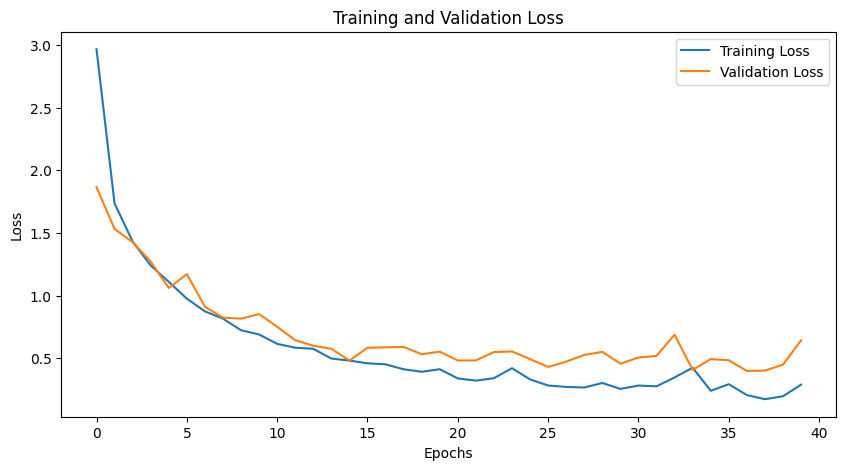

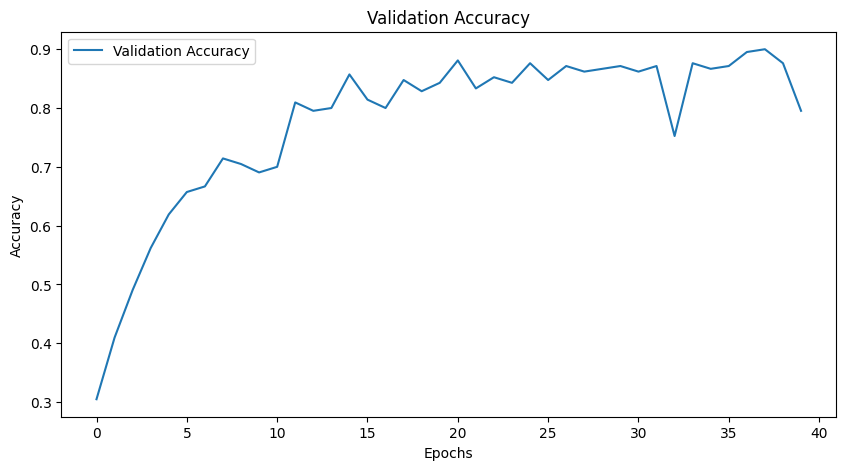

In [20]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
